# EDAN95 - Applied Machine Learning
### LTH Fall 2019

# Lab 3
### David Larsson & Jonas Lundgren

## Collecting a Dataset

Code from https://github.com/pnugues/edan95.

In [1]:
import os
import random
import shutil

In [2]:
# To create the same dataset
random.seed(0)

original_dataset_dir = "flowers-recognition/flowers"
dataset = "flowers-recognition/flowers_split"

train_dir = os.path.join(dataset, 'train')
validation_dir = os.path.join(dataset, 'validation')
test_dir = os.path.join(dataset, 'test')

categories = os.listdir(original_dataset_dir)
categories = [category for category in categories if not category.startswith('.')]
print('Image types:', categories)
data_folders = [os.path.join(original_dataset_dir, category) for category in categories]

pairs = []
for folder, category in zip(data_folders, categories):
    images = os.listdir(folder)
    images = [image for image in images if not image.startswith('.')]
    pairs.extend([(image, category) for image in images])
    
random.shuffle(pairs)
img_nbr = len(pairs)
train_images = pairs[0:int(0.6 * img_nbr)]
val_images = pairs[int(0.6 * img_nbr):int(0.8 * img_nbr)]
test_images = pairs[int(0.8 * img_nbr):]

# print(train_images)
print(len(train_images))
print(len(val_images))
print(len(test_images))


for image, label in train_images:
    src = os.path.join(original_dataset_dir, label, image)
    dst = os.path.join(train_dir, label, image)
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copyfile(src, dst)

for image, label in val_images:
    src = os.path.join(original_dataset_dir, label, image)
    dst = os.path.join(validation_dir, label, image)
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copyfile(src, dst)

for image, label in test_images:
    src = os.path.join(original_dataset_dir, label, image)
    dst = os.path.join(test_dir, label, image)
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copyfile(src, dst)

Image types: ['dandelion', 'daisy', 'tulip', 'rose', 'sunflower']
2595
865
866


## Building a Simple Convolutional Neural Network

In [3]:
import numpy as np
import matplotlib.pyplot as plt
#from PIL import Image
from IPython.display import Image, display
%matplotlib inline  

Chceck some random flowers

dandelion


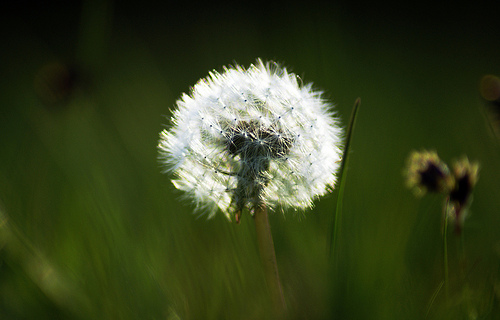

daisy


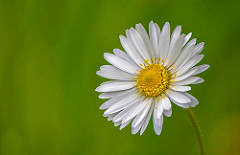

daisy


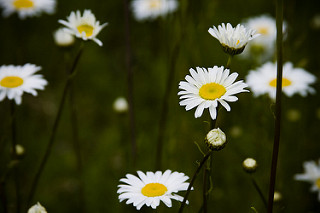

dandelion


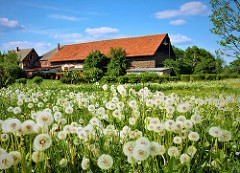

tulip


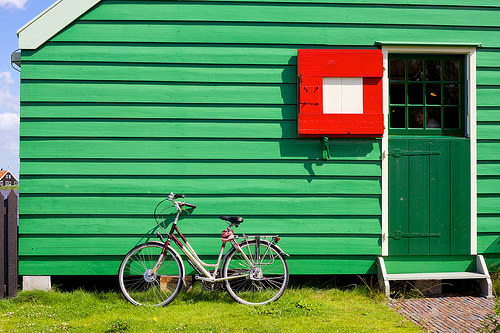

In [4]:
num_flowers = 5
random_flowers_idx = np.random.randint(0, len(train_images), num_flowers)
random_flowers = [train_images[i] for i in random_flowers_idx]

for image, label in random_flowers:
    src = os.path.join(train_dir, label, image)
    print(label)
    display(Image(filename=src))
    #im = Image.open(src)
    #im.show()


### 1.1 

In [5]:
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [6]:
model = models.Sequential()
model.add(layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu',
                        input_shape = (150, 150, 3)))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(5, activation = 'softmax'))

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

In [8]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.RMSprop(lr = 1e-4),
              metrics = ['acc'])

In [9]:
train_datagen = ImageDataGenerator(rescale = 1. / 255)
val_datagen = ImageDataGenerator(rescale = 1. / 255)
test_datagen = ImageDataGenerator(rescale = 1. / 255)

In [22]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (150,150),
                                                    batch_size = 20,
                                                    classes = ['dandelion', 'daisy', 'tulip', 'rose', 'sunflower'],
                                                    class_mode = 'categorical')
validation_generator = val_datagen.flow_from_directory(validation_dir,
                                                       target_size = (150,150),
                                                       batch_size = 20,
                                                       classes = ['dandelion', 'daisy', 'tulip', 'rose', 'sunflower'],
                                                       class_mode = 'categorical')
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  shuffle = False,
                                                  target_size = (150,150),
                                                  batch_size = 20,
                                                  classes = ['dandelion', 'daisy', 'tulip', 'rose', 'sunflower'],
                                                  class_mode = 'categorical')

Found 2758 images belonging to 5 classes.
Found 865 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


In [23]:
retrain_model = False
if retrain_model:
    history = model.fit_generator(train_generator,
                                  steps_per_epoch = 100,
                                  epochs = 30, 
                                  validation_data = validation_generator,
                                  validation_steps = 50)

In [24]:
if retrain_model:
    model.save_weights('model_1_lab3.model')
else:
    model.load_weights('model_1_lab3.model')

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validaion accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training acc')
plt.plot(epochs, val_loss, 'b', label = 'Validation acc')
plt.title('Training and Validaion loss')
plt.legend()

plt.show()

NameError: name 'history' is not defined

### 1.2

In [26]:
y_hat = model.predict_generator(test_generator)
y_pred = np.argmax(y_hat, axis=1)
y = test_generator.classes

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print('Accuracy :', accuracy_score(y,y_pred))
print('Confusion Matrix :\n', confusion_matrix(y, y_pred))

Accuracy : 0.692485549132948
Confusion Matrix :
 [[175  20   8  11  14]
 [ 22 119   1  14   6]
 [ 13  13  82  62  16]
 [  2  15  16 111   5]
 [ 14   5   5   4 112]]


### 1.3

Added 1 more layer and dropout for last layer.

In [44]:
model2 = models.Sequential()
model2.add(layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu',
                        input_shape = (150, 150, 3)))
model2.add(layers.MaxPool2D(pool_size = (2, 2)))
model2.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model2.add(layers.MaxPool2D(pool_size = (2, 2)))
model2.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
model2.add(layers.MaxPool2D(pool_size = (2, 2)))
model2.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
model2.add(layers.MaxPool2D(pool_size = (2, 2)))
model2.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
model2.add(layers.MaxPool2D(pool_size = (2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(512, activation = 'relu'))
model2.add(layers.Dense(5, activation = 'softmax'))

model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 15, 15, 128)      

Using Adam as optimizer.

In [45]:
model2.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.adam(lr = 1e-4),
              metrics = ['acc'])

In [46]:
retrain_model = False
if retrain_model:
    history = model2.fit_generator(train_generator,
                                  steps_per_epoch = 100,
                                  epochs = 30, 
                                  validation_data = validation_generator,
                                  validation_steps = 50)

Epoch 1/30
100/100 [==============================] - 58s 575ms/step - loss: 1.5366 - acc: 0.2750 - val_loss: 1.1354 - val_acc: 0.4061
Epoch 2/30
100/100 [==============================] - 93s 929ms/step - loss: 1.3178 - acc: 0.4054 - val_loss: 1.1893 - val_acc: 0.4091
Epoch 3/30
100/100 [==============================] - 99s 994ms/step - loss: 1.2106 - acc: 0.4600 - val_loss: 1.5706 - val_acc: 0.4944
Epoch 4/30
100/100 [==============================] - 108s 1s/step - loss: 1.2010 - acc: 0.4875 - val_loss: 1.1842 - val_acc: 0.5310
Epoch 5/30
100/100 [==============================] - 88s 885ms/step - loss: 1.1470 - acc: 0.5125 - val_loss: 1.0913 - val_acc: 0.5665
Epoch 6/30
100/100 [==============================] - 66s 656ms/step - loss: 1.0923 - acc: 0.5480 - val_loss: 1.0061 - val_acc: 0.5543
Epoch 7/30
100/100 [==============================] - 99s 988ms/step - loss: 1.0694 - acc: 0.5656 - val_loss: 1.2591 - val_acc: 0.5401
Epoch 8/30
100/100 [==============================] - 72s

In [84]:
if retrain_model:
    model2.save_weights('model_2_lab3.model')
else:
    model2.load_weights('model_2_lab3.model')

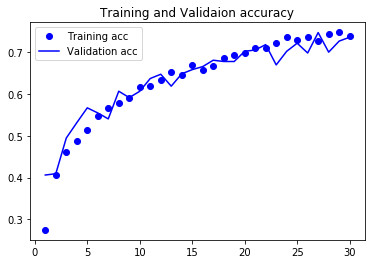

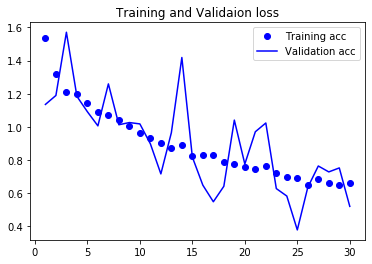

In [48]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validaion accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training acc')
plt.plot(epochs, val_loss, 'b', label = 'Validation acc')
plt.title('Training and Validaion loss')
plt.legend()

plt.show()

In [51]:
y_hat = model2.predict_generator(test_generator)
y_pred = np.argmax(y_hat, axis=1)
y = test_generator.classes

In [52]:
print('Accuracy :', accuracy_score(y,y_pred))
print('Confusion Matrix :\n', confusion_matrix(y, y_pred))

Accuracy : 0.730635838150289
Confusion Matrix :
 [[192   5  11   5  15]
 [ 19 120   6   7  10]
 [ 12  10 119  31  14]
 [ 15   8  38  82   6]
 [ 16   2   3   0 119]]


### 2.1

In [53]:
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

Example image.

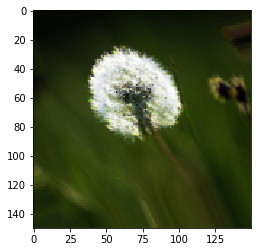

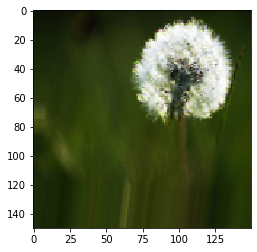

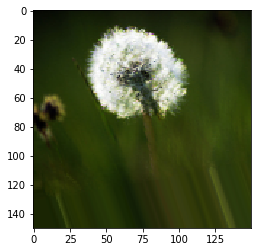

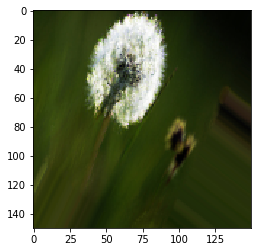

In [75]:
from keras.preprocessing import image

jpg, label = random_flowers[0]
img_path = os.path.join(train_dir, label, jpg)
img = image.load_img(img_path, target_size=(150, 150))

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

for i, batch in zip(range(4), datagen.flow(x, batch_size = 1)):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
                    
plt.show()

In [78]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,)


val_datagen = ImageDataGenerator(rescale = 1. / 255)
test_datagen = ImageDataGenerator(rescale = 1. / 255)

In [79]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (150,150),
                                                    batch_size = 20,
                                                    classes = ['dandelion', 'daisy', 'tulip', 'rose', 'sunflower'],
                                                    class_mode = 'categorical')
validation_generator = val_datagen.flow_from_directory(validation_dir,
                                                       target_size = (150,150),
                                                       batch_size = 20,
                                                       classes = ['dandelion', 'daisy', 'tulip', 'rose', 'sunflower'],
                                                       class_mode = 'categorical')
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  shuffle = False,
                                                  target_size = (150,150),
                                                  batch_size = 20,
                                                  classes = ['dandelion', 'daisy', 'tulip', 'rose', 'sunflower'],
                                                  class_mode = 'categorical')

Found 2758 images belonging to 5 classes.
Found 865 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


In [81]:
model3 = models.Sequential()
model3.add(layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu',
                        input_shape = (150, 150, 3)))
model3.add(layers.MaxPool2D(pool_size = (2, 2)))
model3.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model3.add(layers.MaxPool2D(pool_size = (2, 2)))
model3.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
model3.add(layers.MaxPool2D(pool_size = (2, 2)))
model3.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
model3.add(layers.MaxPool2D(pool_size = (2, 2)))
model3.add(layers.Flatten())
model3.add(layers.Dense(512, activation = 'relu'))
model3.add(layers.Dense(5, activation = 'softmax'))
model3.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 15, 15, 128)      

In [82]:
model3.compile(loss = 'categorical_crossentropy',
               optimizer = optimizers.RMSprop(lr = 1e-4),
               metrics = ['acc'])

In [83]:
retrain_model = True
if retrain_model:
    history = model3.fit_generator(train_generator,
                                  steps_per_epoch = 100,
                                  epochs = 30, 
                                  validation_data = validation_generator,
                                  validation_steps = 50)

Epoch 1/30
100/100 [==============================] - 72s 719ms/step - loss: 1.4114 - acc: 0.3755 - val_loss: 1.1998 - val_acc: 0.4924
Epoch 2/30
100/100 [==============================] - 66s 659ms/step - loss: 1.2292 - acc: 0.4625 - val_loss: 1.7870 - val_acc: 0.5218
Epoch 3/30
100/100 [==============================] - 66s 656ms/step - loss: 1.1544 - acc: 0.5280 - val_loss: 0.9777 - val_acc: 0.5513
Epoch 4/30
100/100 [==============================] - 66s 658ms/step - loss: 1.1207 - acc: 0.5420 - val_loss: 1.0811 - val_acc: 0.5706
Epoch 5/30
100/100 [==============================] - 63s 634ms/step - loss: 1.0792 - acc: 0.5710 - val_loss: 1.1395 - val_acc: 0.6041
Epoch 6/30
100/100 [==============================] - 63s 635ms/step - loss: 1.0596 - acc: 0.5832 - val_loss: 1.5526 - val_acc: 0.5574
Epoch 7/30
100/100 [==============================] - 63s 634ms/step - loss: 1.0237 - acc: 0.5810 - val_loss: 1.2466 - val_acc: 0.6051
Epoch 8/30
100/100 [==============================] - 6

In [85]:
if retrain_model:
    model3.save_weights('model_3_lab3.model')
else:
    model3.load_weights('model_3_lab3.model')

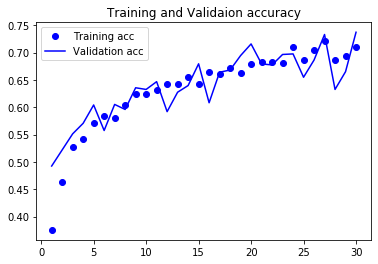

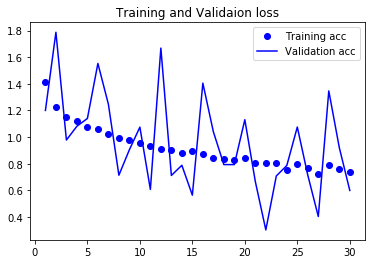

In [86]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validaion accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training acc')
plt.plot(epochs, val_loss, 'b', label = 'Validation acc')
plt.title('Training and Validaion loss')
plt.legend()

plt.show()

In [87]:
y_hat = model3.predict_generator(test_generator)
y_pred = np.argmax(y_hat, axis=1)
y = test_generator.classes

In [88]:
print('Accuracy :', accuracy_score(y,y_pred))
print('Confusion Matrix :\n', confusion_matrix(y, y_pred))

Accuracy : 0.7225433526011561
Confusion Matrix :
 [[197   3   6   3  19]
 [ 23 108   6  10  15]
 [ 14   5 118  34  15]
 [ 15   4  45  79   6]
 [ 10   1   5   1 123]]
